# Random Forest2 1,2     FilterPercentil80_20  at least 100 days with info

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
seed=2020

In [20]:
# Loading dataframes for 1 and 2 occupants
filePath = ''
df1 = pd.read_csv(filePath + '.csv', index_col=0).drop('0',axis=1)
df2 = pd.read_csv(filePath + '.csv', index_col=0).drop('0',axis=1)

df = pd.concat([df1, df2])
df = df.reset_index()

# Drop data with missing values
df = df.loc[df.iloc[:, 22:].dropna().index]
print(df.shape)
# Resample dataframe
resample_value = df['Number of Occupants'].value_counts().min()
df = pd.concat([
    df[df['Number of Occupants'] == 1].sample(resample_value,random_state=seed),
    df[df['Number of Occupants'] == 2].sample(resample_value,random_state=seed)
])
df = df.sample(frac=1,random_state=seed).reset_index(drop=True)
print(df.shape)
# Split into X and y
X = df.iloc[:, 22:]
y = df['Number of Occupants']



(1284, 2038)
(1284, 2038)


In [21]:
X = X.iloc[:, ~( (X.columns.str.contains('Sunday')) | (X.columns.str.contains('Saturday'))  )]

In [22]:
# Processing
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True,random_state=seed)

In [24]:
#I vary the parameters 'criterion':['entropy','gini'], 'n_estimators':[50,100,150,200], 'max depth':[5,10,15,20], ', min_samples_leaf':[1,5,10,15,20]
parameters = [
    {
        'criterion' :['entropy'],
        'n_estimators' : [50,100],
        'bootstrap' : [True],
        'max_features' : ['auto'],
        'random_state': [0], 
        'max_depth': [3,4,5,9,10,11,12,15],
        'min_samples_leaf': [1,3,5,10,15,20]
        
    }
]
clf = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=kf)
clf.fit(X=X, y=y)#(X=X_train, y=y_train)
clf.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 100,
 'random_state': 0}

# With cross validation

Accuracy: 0.70 (+/- 0.10)


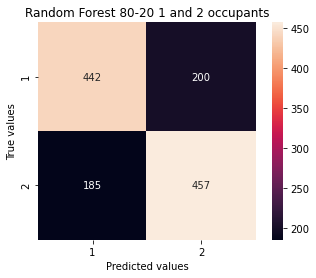

In [25]:
#I use the parameters that I obtained before, to train and test the final model with kfold
n_splits=5
model=RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'auto',random_state=0, max_depth=15,criterion='entropy',min_samples_leaf=3)#(n_estimators=150, bootstrap = True, max_features = 'auto',random_state=0, max_depth=4,criterion='entropy',min_samples_leaf=5)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
scores = cross_val_score(model, X, y, cv=kf)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#---------------------------------------------------------------------
y_pred_cv = cross_val_predict(model,X,y,cv=kf)
matrix = pd.DataFrame(
    confusion_matrix(y, y_pred_cv), 
    columns=range(1, y.max()+1), 
    index=range(1, y.max()+1)
)
sns.heatmap(matrix, annot=True, fmt='.0f', square=True)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest 80-20 1 and 2 occupants')
plt.show()